In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [8]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

batch_size = 256


transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class MNISTImagesOnly(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)
        
    def __len__(self):
        return len(self.dataset)
    
    
    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        return image


dataset = MNISTImagesOnly('mnist_data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

data_iter = iter(dataloader)
images = next(data_iter)
print(f"Shape of batch: {images.shape}")


Shape of batch: torch.Size([256, 1, 32, 32])


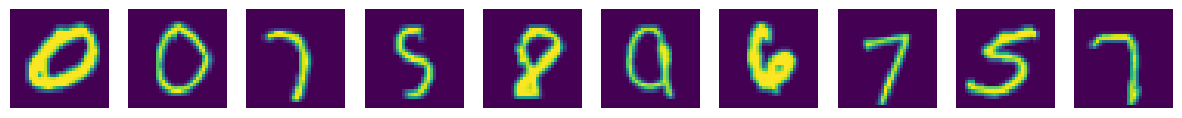

In [11]:
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    plt.imshow(img * 0.5 + 0.5)
    plt.axis('off')
plt.show()

In [2]:
import torch
import torch.nn as nn

class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise_dim = 128
        self.image_channels = 1
        self.criterion = nn.BCEWithLogitsLoss()

        self.generator = nn.Sequential(
            nn.Linear(self.noise_dim, 8 * 8 * 256, bias=False),
            nn.BatchNorm1d(8 * 8 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 256, 3, 1, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, self.image_channels, 3, 1, 1, bias=False),
            # nn.Sigmoid()
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            nn.Conv2d(self.image_channels, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Conv2d(128, 128, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(64, 1),
            # nn.Sigmoid()
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, noise):
        return self.generator(noise)

    def generator_loss(self, fake_preds):
        target = torch.ones_like(fake_preds)
        return self.criterion(fake_preds, target)

    def discriminator_loss(self, real_preds, fake_preds):
        real_targets = torch.empty_like(real_preds).uniform_(0.9, 1.0)
        fake_targets = torch.empty_like(fake_preds).uniform_(0.0, 0.1)

        real_loss = self.criterion(real_preds, real_targets)
        fake_loss = self.criterion(fake_preds, fake_targets)

        return real_loss + fake_loss

    def training_step(self, real_images, batch_size, device, gen_optimizer, disc_optimizer):
        noise = torch.normal(mean=0, std=1, size=(batch_size, self.noise_dim)).to(device)
        fake_images = self.generator(noise)

        disc_optimizer.zero_grad()
        real_preds = self.discriminator(real_images)
        fake_preds = self.discriminator(fake_images.detach())
        d_loss = self.discriminator_loss(real_preds, fake_preds)
        d_loss.backward()
        disc_optimizer.step()

        gen_optimizer.zero_grad()
        fake_preds = self.discriminator(fake_images)
        g_loss = self.generator_loss(fake_preds)
        g_loss.backward()
        gen_optimizer.step()

        return d_loss.item(), g_loss.item()


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAN().to(device)

# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

lr_g = 5e-4
lr_d = 2e-4
gen_optimizer = optim.Adam(model.generator.parameters(), lr=lr_g)
disc_optimizer = optim.Adam(model.discriminator.parameters(), lr=lr_d)

In [4]:
import matplotlib.pyplot as plt

def generate(model):
    model.eval()  

    data_iter = iter(dataloader)
    real_images = next(data_iter)[:3]  
    real_images = real_images.to(device)

  
    noise = torch.normal(mean=0, std=1, size=(batch_size, model.noise_dim)).to(device)
    fake_images = model.generator(noise)

   
    real_preds = model.discriminator(real_images)
    fake_preds = model.discriminator(fake_images)

 
    fig, axes = plt.subplots(2, 3, figsize=(9, 6))
    for i in range(3):
        axes[0, i].imshow(real_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5) 
        axes[0, i].set_title(f"Real, Loss: {real_preds[i].item():.4f}")
        axes[0, i].axis("off")

        axes[1, i].imshow(fake_images[i].cpu().detach().permute(1, 2, 0))  
        axes[1, i].set_title(f"Fake, Loss: {fake_preds[i].item():.4f}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

    model.train() 
generate(model)

NameError: name 'dataloader' is not defined

50


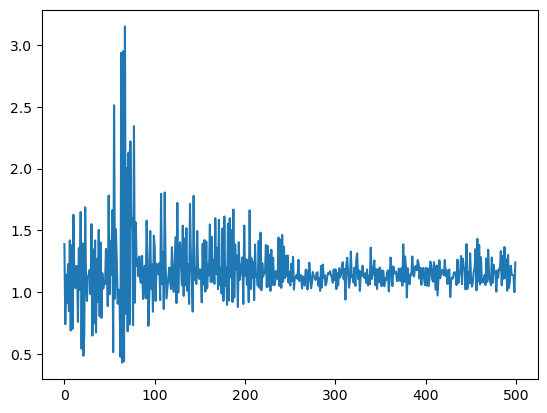

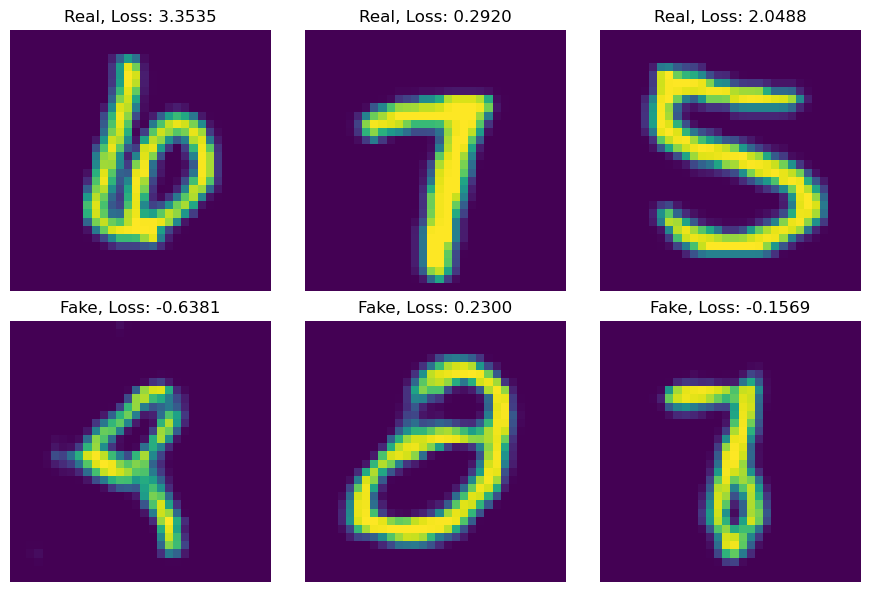

In [20]:
epochs = 50
from IPython.display import clear_output
hist = np.array(np.empty([0]))

for epoch in range(1, epochs + 1):
    for step, x in enumerate(dataloader):
        
        real_images = x.to(device)
        loss = model.training_step(
            real_images, batch_size, device,
            gen_optimizer, disc_optimizer
        )

        if step % 50 == 0:
            clear_output(wait=True)
            print(epoch)
            hist = np.append(hist, loss)
            plt.plot(np.arange(0, len(hist)), hist)
            plt.show()
            generate()

In [21]:
torch.save(model.state_dict(), 'gan_weights.pth')

print("Веса модели успешно сохранены в 'gan_weights.pth'.")

Веса модели успешно сохранены в 'gan_weights.pth'.


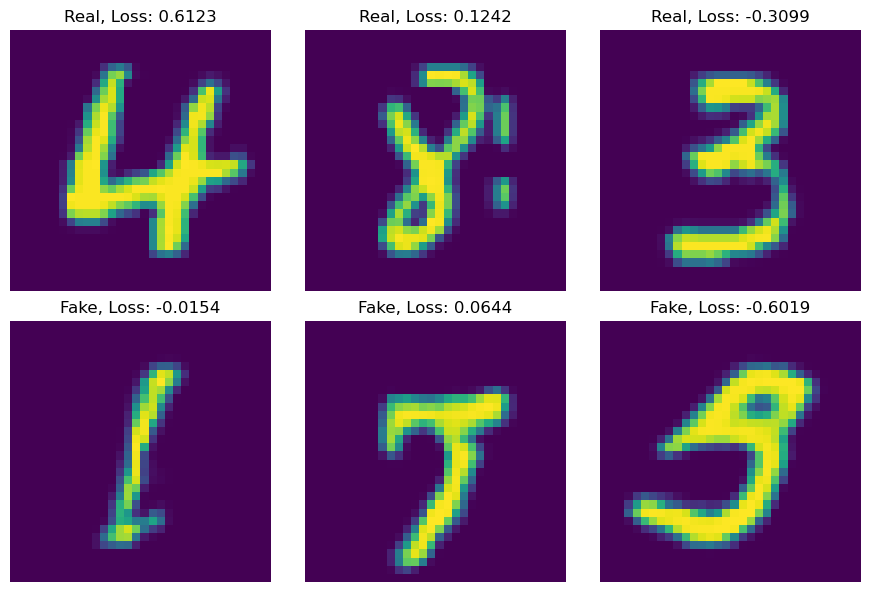

In [10]:
model_with_load = GAN().to(device) 
model_with_load.load_state_dict(torch.load('gan_weights.pth'))
generate(model_with_load)